In [37]:
from utils import *
from utils2 import *
from utils3 import *
from plotting import *
from gpcrdb_soup import *

In [38]:
from tqdm import tqdm, trange

In [474]:
import sys
import pandas
import gemmi
from gemmi import cif
import random

In [740]:
class CifProcessor():
    def __init__(self, 
                 path = 'data/',
                 structure = 'mmcif/',
                 limit=10, 
                 reload=True,
                 remove_hetatm=True):
        self.path = path
        self.structure_path = self.path + structure
        self.path_table = path + 'gpcrdb/' + 'structures.pkl'
        
        self.limit = limit
        self.reload = reload
        self.remove_hetatm = remove_hetatm
        
        self.filenames, self.pdb_ids = self.get_pdb_files()
        if self.limit == None:
            self.limit = len(self.pdb_ids)
        # Columns for structure dataframe
        self.cols = ['group_PDB', 'auth_asym_id', 'label_asym_id', 'label_seq_id', 'auth_seq_id', 
                     'label_comp_id', 'id', 'label_atom_id', 
                     'type_symbol', 'Cartn_x', 'Cartn_y', 'Cartn_z']
        self.numbering = pd.DataFrame()
                
    # ==============================================================================================================
    
    def get_pdb_files(self):
        # just a helper function that returns all pdb files in specified path
        (_, _, filenames) = next(os.walk(self.structure_path))
        random.shuffle(filenames)
        files = [path + x for x in filenames][:self.limit]
        pdb_ids = list(set([x[-8:-4] for x in files]))
        return files, pdb_ids

    def make_raws(self):
        self.table = pd.read_pickle(self.path_table)
        for i, pdb_id in tqdm(enumerate(self.pdb_ids)):
            if i < self.limit:
                # only process if the file has not already been generated
                # if not self.reload & 
                protein, family = self.get_prot_info(pdb_id)
                numbering = self.get_res_nums(protein)
                if i == 0:
                    self.structure = self.load_cifs(pdb_id)
                    self.structure['identifier'] = protein.upper()
                    if self.remove_hetatm:
                        self.structure = self.structure[self.structure['group_PDB']!='HETATM']
                        self.structure['label_seq_id'] = self.structure['label_seq_id'].astype(np.int64)
                    self.structure['label_comp_sid'] = self.structure.apply(lambda x:
                                                        gemmi.find_tabulated_residue(x.label_comp_id).one_letter_code, 
                                                        axis=1)
                    self.mappings = self.get_mapping(pdb_id)
                    numb = [pdb_id, protein, family, numbering]
                    # numb = [pdb_id, protein, self.entry_to_ac(protein), family, numbering]
                    self.numbering = self.numbering.append(pd.DataFrame(numb).T)
                else:
                    structure = self.load_cifs(pdb_id)
                    structure['identifier'] = protein.upper()
                    if self.remove_hetatm:
                        structure = self.structure[self.structure['group_PDB']!='HETATM']
                        structure['label_seq_id'] = self.structure['label_seq_id'].astype(np.int64)
                    structure['label_comp_sid'] = structure.apply(lambda x:
                                                        gemmi.find_tabulated_residue(x.label_comp_id).one_letter_code, 
                                                        axis=1)
                    self.structure = self.structure.append(structure, ignore_index=True)
                    self.mappings = self.mappings.append(self.get_mapping(pdb_id), ignore_index=True)
                    # self.numbering = self.numbering.append(pd.DataFrame(data=[pdb_id, protein, self.entry_to_ac(protein),
                    #                                                           family, numbering]).T, 
                    self.numbering = self.numbering.append(pd.DataFrame(data=[pdb_id, protein, family, numbering]).T, 
                                                           ignore_index=True)
        self.numbering.columns = ['PDB', 'identifier', 'family', 'numbering']
        
        if self.remove_hetatm:
            self.structure = self.structure[self.structure['group_PDB']!='HETATM']
            self.structure['label_seq_id'] = self.structure['label_seq_id'].astype(np.int64)
        self.structure['label_comp_sid'] = self.structure.apply(lambda x:
                                                    gemmi.find_tabulated_residue(x.label_comp_id).one_letter_code, 
                                                    axis=1)
         
    # ==============================================================================================================
        
    def entry_to_ac(self, entry: str):
        query = 'https://www.uniprot.org/uniprot/'+entry+'.txt'
        response = requests.get(query)
        return response.text.split('\n')[1].split('AC   ')[1][:6]
    
    def get_prot_info(self, pdb_id):
        # query structure
        query = 'https://gpcrdb.org/services/structure/'+pdb_id.upper()+'/'
        response = requests.get(query)
        protein = response.json()['protein']
        family = response.json()['family']
        return protein, family
    
    def get_res_nums(self, protein):
        # query uniprot -> res num
        query = 'https://gpcrdb.org/services/residues/extended/'+protein+'/'
        response = requests.get(query)
        # select res num
        # assign res_num to structure data
        return response.json()
    
    def get_mapping(self, pdb_id):
        maps = get_mappings_data(pdb_id)[pdb_id.lower()]['UniProt']
        uniprots = maps.keys()
        full_table=pd.DataFrame()
        for i, uniprot in enumerate(uniprots):
            table = pd.DataFrame.from_dict(maps[uniprot])
            table['PDB'] = pdb_id
            table['uniprot'] = uniprot
            if i == 0:
                full_table = table
            else:
                full_table = full_table.append(table, ignore_index=True)
        return full_table
    
    # ==============================================================================================================
    
    def load_cifs(self, pdb_id):
        print("Loading cif file of", pdb_id)
        path = 'data/mmcif/' + pdb_id + '.cif'
        print(path)
        try:
            doc = cif.read_file(path)  # copy all the data from mmCIF file
            lol = []  # list of lists
            for b, block in enumerate(doc):
                table = block.find('_atom_site.', self.cols)
                for row in table:
                    lol.append([pdb_id]+list(row))
        
        
        except Exception as e:
            print("Oops. %s" % e)
            sys.exit(1)
        cols = ['PDB']+self.cols
        st = gemmi.read_structure(path)
        model = st[0]
        if len(st) > 1:
            print("There are multiple models!")
        rol = []
        for chain in model:
            for r, res in enumerate(chain.get_polymer()):
                # previous_residue() and next_residue() return previous/next
                # residue only if the residues are bonded. Otherwise -- None.
                prev_res = chain.previous_residue(res)
                next_res = chain.next_residue(res)
                try:
                    phi, psi = gemmi.calculate_phi_psi(prev_res, res, next_res)
                except:
                    phi, psi = np.nan, np.nan
                try:
                    omega = gemmi.calculate_omega(res, next_res)
                except:
                    omega = np.nan
                rol.append([res.label_seq, res.subchain, 
                            degrees(phi), degrees(omega), degrees(psi)])
        cols2 = ['label_seq_id', 'label_asym_id', 'phi', 'omega', 'psi']
        rol_df = pd.DataFrame(data=rol, columns=cols2)
        rol_df['label_seq_id'] = rol_df['label_seq_id'].astype(int)
        lol_df = pd.DataFrame(data=lol, columns=cols)
        lol_df['label_seq_id'] = lol_df.apply(lambda x: int(x.label_seq_id) if x.label_seq_id != '.' else np.nan, axis=1)
        return pd.merge(lol_df, rol_df, how='inner', on=['label_asym_id', 'label_seq_id'])    
    
    def read_dfl(self, folder='data/raw/'):
        files = [f for f in listdir(folder) if '.pkl' in f]
        self.dfl = []
        for f in files:
            self.dfl.append(pd.read_pickle(folder+f).reset_index().drop('index', axis=1))
    
    def del_pkl(self, folder='data/raw/'):
        files = [f for f in listdir(folder) if '.pkl' in f]
        for file in files:
            os.remove(folder + file)
    
    def to_pkl(self, folder='data/raw/'):
        for pdb in self.pdb_ids:
            structure = self.structure[self.structure['PDB']==pdb]
            if len(structure) >= 1:
                structure.to_pickle(folder + pdb + '.pkl')
    
    def to_pkl_dfl(self, folder='data/processed'):
        for df in self.dfl:
            pdb_id = df['PDB'].unique()[0]
            df.to_pickle(folder+pdb_id)
            
    def to_pkl_metainfo(self):
        self.numbering.to_pickle(self.path + 'data_numbering.pkl')
        self.table.to_pickle(self.path + 'data_table.pkl')
        self.mappings.to_pickle(self.path + 'data_mappings.pkl')
    
    def read_pkl_metainfo(self):
        self.numbering = pd.read_pickle(self.path + 'data_numbering.pkl')
        self.table = pd.read_pickle(self.path + 'data_table.pkl')
        self.mappings = pd.read_pickle(self.path + 'data_mappings.pkl')
    
    def del_pkl_metainfo(self):
        os.remove(self.path + 'data_numbering.pkl')
        os.remove(self.path + 'data_table.pkl')
        os.remove(self.path + 'data_mappings.pkl')
    
    # ==============================================================================================================    
    
    def get_stacked_maps(self, pdb):
        # add gene to mapping
        mappings_ = self.mappings[self.mappings['PDB']==pdb]
        pref_chain = self.table[self.table['PDB']==pdb]['Preferred Chain'].iloc[0]
        map_df_list = []
        for j in range(len(mappings_)):
            chain = pd.DataFrame.from_dict(mappings_.iloc[j]['mappings'])['chain_id'].iloc[0]
            identifier = mappings_.iloc[j]['name']
            dict_ = pd.DataFrame.from_dict(mappings_.iloc[j]['mappings'])
            dict_['identifier'] = identifier
            map_df_list.append(pd.DataFrame.from_dict(dict_))
        _ = pd.concat(map_df_list)
        _ = _[_['chain_id']==pref_chain]
        _['PDB'] = pdb
        return _


    def get_generic_nums(self, pdb_id):
        sequence_numbers = []
        amino_acids = []
        generic_numbers = []
        for i in self.numbering[self.numbering['PDB']==pdb_id].iloc[0]['numbering']:
            if i['alternative_generic_numbers'] != []:
                sequence_numbers.append(i['sequence_number'])
                amino_acids.append(i['amino_acid'])
                generic_numbers.append(i['display_generic_number'])
        return list(zip(sequence_numbers, amino_acids, generic_numbers))


    def get_generic_number(self, zipped_pos_dict, l2u, comp_sid):
        if l2u >= 0:
            if l2u in list(zip(*zipped_pos_dict))[0]:
                idx = list(zip(*zipped_pos_dict))[0].index(l2u)
                row = zipped_pos_dict[idx]
                if row[1] == comp_sid:
                    # print("found row", row[1], float(row[2].split('x')[0]), int(row[2].split('x')[1]), comp_sid)
                    return row[2], row[1], float(row[2].split('x')[0]), int(row[2].split('x')[1])
                else:
                    # print("found row, but residue are not the same", row, comp_sid)
                    return row[2]+'?', row[1], float(row[2].split('x')[0]), int(row[2].split('x')[1])
            else:
                return ['', '', 0, 0]
        else:
            return ['', '', 0, 0]


    def assign_generic_numbers_(self, pdb_id, overwrite, folder):
        data = pd.read_pickle(folder + pdb_id + '.pkl').reset_index().drop('index', axis=1)
        cols = data.columns
        columns = ['gen_pos', 'gen_pos1', 'gen_pos2', 'uniprot_comp_sid']
        _ = [i for i in columns if i in cols]
        if len(_) > 0:
            if overwrite:
                data.drop(_, axis=1, inplace=True)
                data['label_2_uni'] = 0
                data['gen_pos'] = ''
                data['gen_pos1'] = 0
                data['gen_pos2'] = 0
                data['uniprot_comp_sid'] = ''
            else:
                return data
        
        maps_stacked = self.get_stacked_maps(pdb_id)
        print(maps_stacked.index)
        if type(maps_stacked[maps_stacked['PDB']==pdb_id].\
                loc['residue_number'][['chain_id', 'start','end','unp_start','unp_end', 'identifier', 'PDB']])\
                    == pandas.core.series.Series:
            pref_mapping = maps_stacked[maps_stacked['PDB']==pdb_id].loc['residue_number']\
                [['chain_id', 'start','end','unp_start','unp_end', 'identifier', 'PDB']].to_frame().T
        else:
            pref_mapping = maps_stacked[maps_stacked['PDB']==pdb_id].\
                loc['residue_number'][['chain_id', 'start','end','unp_start','unp_end', 'identifier', 'PDB']]
        print("got preferred mapping.. \n\n")
        pref_chain = pref_mapping['chain_id'].iloc[0]
        pref_mapping = pref_mapping.sort_values('start')
        uniprot_identifier_ = data[data['PDB']==pdb_id]['identifier'].unique()
        uniprot_identifier = uniprot_identifier_[0]
        natoms = len(data[data['PDB']==pdb_id])
        for j in range(len(pref_mapping)):
            row = pref_mapping.iloc[j].to_dict()
            map_identifier = row['identifier']
            map_pdb = row['PDB']
            start_label_seq_id = row['start']
            start_uniprot = row['unp_start']
            end_label_seq_id = row['end']
            end_uniprot = row['unp_end']
            if map_identifier == uniprot_identifier:
                # print('Found correct uniprot map:', uniprot_identifier, map_identifier)
                idxs = [x for x in range(natoms+1) \
                        if ((x <= end_label_seq_id) & (x >= start_label_seq_id))]
                vals = [x + start_uniprot - start_label_seq_id for x in range(natoms+1) \
                        if ((x <= end_label_seq_id) & (x >= start_label_seq_id))]

                for k, idx in enumerate(idxs):
                    line = data[(data['PDB'] == pdb_id) &
                                (data['auth_asym_id'] == pref_chain) &
                                (data['label_seq_id'] == idx) &
                                (data['label_atom_id'] == 'CA')]
                    lines = len(line)
                    if lines > 0:
                        data.at[line.index[0], 'label_2_uni'] = int(vals[k])
            else:
                #print('Didnt find correct uniprotmap (not a gpcr):', map_identifier)
                pass
        
        # Generate generic numbers
        zipped_pos_dict = self.get_generic_nums(pdb_id)
        data[['gen_pos', 'uniprot_comp_sid', 'gen_pos1', 'gen_pos2']] = data.\
            apply(lambda x: self.get_generic_number(zipped_pos_dict, x.label_2_uni, x.label_comp_sid) if x.PDB==pdb_id\
                  else [x.gen_pos, x.uniprot_comp_sid, x.gen_pos1, x.gen_pos2], axis=1, result_type='expand')
        return data
    
    def assign_generic_numbers(self, pdb_ids=None, overwrite=False, folder='data/raw/'):
        dfl_ = []
        del self.structure
        if pdb_ids != None:
            self.pdb_ids = pdb_ids
        if not isinstance(self.pdb_ids, list):
            self.pdb_ids = [self.pdb_ids]
        for pdb_id in self.pdb_ids:
            print("trying to assign generic nubmers to", pdb_id)
            try:
                dfl_.append(self.assign_generic_numbers_(pdb_id, overwrite=overwrite, folder=folder))
            except:
                pass
        self.dfl = dfl_
        del dfl_
        
    
    def plot_angles_for_gen_pos(self, region=[7.40, 7.60]):
        categories = []
        for df in self.dfl:
            category = np.unique(df['PDB'])[0]
            categories.append(category)
        # categories = list(set(categories))

        cmap = plt.cm.get_cmap('RdYlGn', len(categories))
        colors = np.linspace(0, len(categories)-1, len(categories))
        colordict = dict(zip(categories,colors))


        fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(24,12))

        xlabel = 'generic position numbers'
        ylabel = 'degrees'

        xtick_min = region[0]
        xtick_max = region[1]

        nsteps = int(round(xtick_max - xtick_min, 2) / 0.01)
        xticks = np.linspace(xtick_min, xtick_max, nsteps+1)

        for i, cat in enumerate(categories):
            c = int(colordict[cat])
            df = self.dfl[i]
            roi = df[(df['gen_pos1']>=region[0]) & 
                     (df['gen_pos1']<region[1]) & 
                     (df['label_atom_id']=='CA')].copy()
            roi['phi'] = roi.apply(lambda x: float(x.phi), axis=1)
            roi['omega'] = roi.apply(lambda x: float(x.omega), axis=1)
            roi['psi'] = roi.apply(lambda x: float(x.psi), axis=1)
            tot_len = len(roi['phi'].to_list())+len(roi['omega'].to_list())+len(roi['psi'].to_list())
            if tot_len > 0:
                roi.plot(kind='line', x='gen_pos1', y='phi', 
                        ax = axes[0], subplots = True, color = cmap(c), 
                        xticks = xticks, label=cat)
                axes[0].legend(bbox_to_anchor=(1.0, 1.0))
                axes[0].set_xlabel(xlabel)
                axes[0].set_ylabel(ylabel)
                axes[0].set_title('Psi Angles')

                roi.plot(kind='line', x='gen_pos1', y='psi', 
                        ax = axes[1], subplots = True, color = cmap(c), 
                        xticks = xticks, label=cat)
                axes[1].legend(bbox_to_anchor=(1.0, 1.0))
                axes[1].set_xlabel(xlabel)
                axes[1].set_ylabel(ylabel)
                axes[1].set_title('Phi Angles')
        plt.show()


In [741]:
data = CifProcessor(limit=None)

In [ ]:
data.make_raws()

0it [00:00, ?it/s]

Loading cif file of 3KJ6
data/mmcif/3KJ6.cif
getting the mapping...


1it [00:03,  3.48s/it]

got the mapping
Loading cif file of 6ME5
data/mmcif/6ME5.cif
getting the mapping...


2it [00:06,  3.35s/it]

got the mapping
Loading cif file of 6KK1
data/mmcif/6KK1.cif


3it [00:10,  3.44s/it]

getting the mapping...
got the mapping
Loading cif file of 7DDZ
data/mmcif/7DDZ.cif


4it [00:13,  3.30s/it]

getting the mapping...
got the mapping
Loading cif file of 4PXF
data/mmcif/4PXF.cif


5it [00:16,  3.17s/it]

getting the mapping...
got the mapping
Loading cif file of 3PWH
data/mmcif/3PWH.cif


6it [00:18,  3.09s/it]

getting the mapping...
got the mapping
Loading cif file of 6N4B
data/mmcif/6N4B.cif


7it [00:22,  3.18s/it]

getting the mapping...
got the mapping
Loading cif file of 5CXV
data/mmcif/5CXV.cif


8it [00:25,  3.08s/it]

getting the mapping...
got the mapping
Loading cif file of 6HLP
data/mmcif/6HLP.cif


9it [00:27,  3.00s/it]

getting the mapping...
got the mapping
Loading cif file of 3OE8
data/mmcif/3OE8.cif
getting the mapping...
got the mapping


10it [00:31,  3.24s/it]

Loading cif file of 6MEO
data/mmcif/6MEO.cif
getting the mapping...


11it [00:35,  3.29s/it]

got the mapping
Loading cif file of 6KPC
data/mmcif/6KPC.cif
getting the mapping...
got the mapping


12it [00:37,  3.11s/it]

Loading cif file of 4Z35
data/mmcif/4Z35.cif


13it [00:40,  3.07s/it]

getting the mapping...
got the mapping
Loading cif file of 6KPF
data/mmcif/6KPF.cif


14it [00:44,  3.19s/it]

getting the mapping...
got the mapping
Loading cif file of 2YDV
data/mmcif/2YDV.cif


15it [00:47,  3.14s/it]

getting the mapping...
got the mapping
Loading cif file of 6PS0
data/mmcif/6PS0.cif


16it [00:50,  3.01s/it]

getting the mapping...
got the mapping
Loading cif file of 3CAP
data/mmcif/3CAP.cif


17it [00:53,  3.14s/it]

getting the mapping...
got the mapping
Loading cif file of 6PRZ
data/mmcif/6PRZ.cif


18it [00:56,  3.06s/it]

getting the mapping...
got the mapping
Loading cif file of 5K2B
data/mmcif/5K2B.cif


19it [00:59,  2.97s/it]

getting the mapping...
got the mapping
Loading cif file of 6C1R
data/mmcif/6C1R.cif


20it [01:01,  2.92s/it]

getting the mapping...
got the mapping
Loading cif file of 3P0G
data/mmcif/3P0G.cif


21it [01:04,  2.92s/it]

getting the mapping...
got the mapping
Loading cif file of 6NWE
data/mmcif/6NWE.cif


22it [01:07,  2.90s/it]

getting the mapping...
got the mapping
Loading cif file of 2Y01
data/mmcif/2Y01.cif
getting the mapping...


23it [01:10,  2.96s/it]

got the mapping
Loading cif file of 5TGZ
data/mmcif/5TGZ.cif


24it [01:14,  3.22s/it]

getting the mapping...
got the mapping
Loading cif file of 6H7L
data/mmcif/6H7L.cif


25it [01:17,  3.27s/it]

getting the mapping...
got the mapping
Loading cif file of 6UP7
data/mmcif/6UP7.cif


26it [01:21,  3.27s/it]

getting the mapping...
got the mapping
Loading cif file of 4JKV
data/mmcif/4JKV.cif
getting the mapping...
got the mapping


27it [01:25,  3.47s/it]

Loading cif file of 7CKX
data/mmcif/7CKX.cif


28it [01:28,  3.42s/it]

getting the mapping...
got the mapping
Loading cif file of 1HZX
data/mmcif/1HZX.cif


29it [01:31,  3.35s/it]

getting the mapping...
got the mapping
Loading cif file of 6TP6
data/mmcif/6TP6.cif
getting the mapping...
got the mapping


30it [01:35,  3.35s/it]

Loading cif file of 7DFP
data/mmcif/7DFP.cif


31it [01:38,  3.44s/it]

getting the mapping...
got the mapping
Loading cif file of 5DYS
data/mmcif/5DYS.cif


32it [01:41,  3.30s/it]

getting the mapping...
got the mapping
Loading cif file of 4UHR
data/mmcif/4UHR.cif


33it [01:44,  3.20s/it]

getting the mapping...
got the mapping
Loading cif file of 6FK8
data/mmcif/6FK8.cif


34it [01:47,  3.18s/it]

getting the mapping...
got the mapping
Loading cif file of 5WS3
data/mmcif/5WS3.cif


35it [01:50,  3.20s/it]

getting the mapping...
got the mapping
Loading cif file of 6WGT
data/mmcif/6WGT.cif
getting the mapping...


36it [01:54,  3.37s/it]

got the mapping
Loading cif file of 2YCW
data/mmcif/2YCW.cif


37it [01:58,  3.35s/it]

getting the mapping...
got the mapping
Loading cif file of 6C1Q
data/mmcif/6C1Q.cif


38it [02:01,  3.33s/it]

getting the mapping...
got the mapping
Loading cif file of 6WH4
data/mmcif/6WH4.cif


39it [02:05,  3.50s/it]

getting the mapping...
got the mapping
Loading cif file of 7KNU
data/mmcif/7KNU.cif


40it [02:08,  3.44s/it]

getting the mapping...
got the mapping
Loading cif file of 5D5A
data/mmcif/5D5A.cif


41it [02:11,  3.43s/it]

getting the mapping...
got the mapping
Loading cif file of 6PS4
data/mmcif/6PS4.cif


42it [02:15,  3.42s/it]

getting the mapping...
got the mapping
Loading cif file of 5OLO
data/mmcif/5OLO.cif


43it [02:18,  3.33s/it]

getting the mapping...
got the mapping
Loading cif file of 7CFN
data/mmcif/7CFN.cif


44it [02:21,  3.33s/it]

getting the mapping...
got the mapping
Loading cif file of 5X93
data/mmcif/5X93.cif
getting the mapping...
got the mapping


45it [02:25,  3.34s/it]

Loading cif file of 4YAY
data/mmcif/4YAY.cif
getting the mapping...
got the mapping


46it [02:28,  3.38s/it]

Loading cif file of 6UO9
data/mmcif/6UO9.cif
getting the mapping...
got the mapping


47it [02:32,  3.48s/it]

Loading cif file of 3ZPR
data/mmcif/3ZPR.cif


48it [02:35,  3.49s/it]

getting the mapping...
got the mapping
Loading cif file of 3OE6
data/mmcif/3OE6.cif
getting the mapping...


49it [02:39,  3.51s/it]

got the mapping
Loading cif file of 4QIN
data/mmcif/4QIN.cif
getting the mapping...


50it [02:43,  3.69s/it]

got the mapping
Loading cif file of 4N6H
data/mmcif/4N6H.cif
getting the mapping...
got the mapping


51it [02:47,  3.64s/it]

Loading cif file of 6WHA
data/mmcif/6WHA.cif
getting the mapping...


52it [02:51,  3.92s/it]

got the mapping
Loading cif file of 5CGD
data/mmcif/5CGD.cif
getting the mapping...


53it [02:55,  3.77s/it]

got the mapping
Loading cif file of 6GT3
data/mmcif/6GT3.cif
getting the mapping...


54it [02:58,  3.76s/it]

got the mapping
Loading cif file of 5DGY
data/mmcif/5DGY.cif


55it [03:04,  4.27s/it]

getting the mapping...
got the mapping
Loading cif file of 4RWD
data/mmcif/4RWD.cif


56it [03:08,  4.21s/it]

getting the mapping...
got the mapping
Loading cif file of 4LDE
data/mmcif/4LDE.cif


57it [03:11,  4.04s/it]

getting the mapping...
got the mapping
Loading cif file of 5NDD
data/mmcif/5NDD.cif


58it [03:15,  3.83s/it]

getting the mapping...
got the mapping
Loading cif file of 4PXZ
data/mmcif/4PXZ.cif


59it [03:18,  3.64s/it]

getting the mapping...
got the mapping
Loading cif file of 6DDF
data/mmcif/6DDF.cif
getting the mapping...


60it [03:22,  3.67s/it]

got the mapping
Loading cif file of 5XR8
data/mmcif/5XR8.cif
getting the mapping...


61it [03:25,  3.64s/it]

got the mapping
Loading cif file of 6AKX
data/mmcif/6AKX.cif


62it [03:29,  3.55s/it]

getting the mapping...
got the mapping
Loading cif file of 6IBB
data/mmcif/6IBB.cif


63it [03:32,  3.63s/it]

getting the mapping...
got the mapping
Loading cif file of 6ME7
data/mmcif/6ME7.cif


64it [03:36,  3.61s/it]

getting the mapping...
got the mapping
Loading cif file of 3QAK
data/mmcif/3QAK.cif


65it [03:40,  3.61s/it]

getting the mapping...
got the mapping
Loading cif file of 6WWZ
data/mmcif/6WWZ.cif
getting the mapping...
got the mapping


66it [03:43,  3.69s/it]

Loading cif file of 6WPW
data/mmcif/6WPW.cif


67it [03:47,  3.78s/it]

getting the mapping...
got the mapping
Loading cif file of 7LCK
data/mmcif/7LCK.cif
getting the mapping...


68it [03:51,  3.75s/it]

got the mapping
Loading cif file of 5DSG
data/mmcif/5DSG.cif


69it [03:55,  3.92s/it]

getting the mapping...
got the mapping
Loading cif file of 7CKW
data/mmcif/7CKW.cif


70it [03:59,  3.95s/it]

getting the mapping...
got the mapping
Loading cif file of 3VGA
data/mmcif/3VGA.cif


71it [04:04,  3.97s/it]

getting the mapping...
got the mapping
Loading cif file of 6OT0
data/mmcif/6OT0.cif


72it [04:08,  4.20s/it]

getting the mapping...
got the mapping
Loading cif file of 5YWY
data/mmcif/5YWY.cif


73it [04:12,  4.17s/it]

getting the mapping...
got the mapping
Loading cif file of 4J4Q
data/mmcif/4J4Q.cif
getting the mapping...


74it [04:16,  4.04s/it]

got the mapping
Loading cif file of 7C7Q
data/mmcif/7C7Q.cif


75it [04:20,  4.10s/it]

getting the mapping...
got the mapping
Loading cif file of 6TOS
data/mmcif/6TOS.cif


76it [04:24,  4.09s/it]

getting the mapping...
got the mapping
Loading cif file of 6KO5
data/mmcif/6KO5.cif


77it [04:29,  4.21s/it]

getting the mapping...
got the mapping
Loading cif file of 4ZJ8
data/mmcif/4ZJ8.cif


78it [04:33,  4.09s/it]

getting the mapping...
got the mapping
Loading cif file of 4IB4
data/mmcif/4IB4.cif
getting the mapping...
got the mapping


79it [04:36,  3.96s/it]

Loading cif file of 6LFM
data/mmcif/6LFM.cif


80it [04:41,  4.25s/it]

getting the mapping...
got the mapping
Loading cif file of 7LJD
data/mmcif/7LJD.cif
getting the mapping...


81it [04:46,  4.38s/it]

got the mapping
Loading cif file of 5K2D
data/mmcif/5K2D.cif
getting the mapping...


82it [04:51,  4.43s/it]

got the mapping
Loading cif file of 3PQR
data/mmcif/3PQR.cif


83it [04:54,  4.29s/it]

getting the mapping...
got the mapping
Loading cif file of 6OMM
data/mmcif/6OMM.cif


84it [04:59,  4.29s/it]

getting the mapping...
got the mapping
Loading cif file of 5EE7
data/mmcif/5EE7.cif


85it [05:03,  4.16s/it]

getting the mapping...
got the mapping
Loading cif file of 7C7S
data/mmcif/7C7S.cif
getting the mapping...
got the mapping


86it [05:07,  4.32s/it]

Loading cif file of 5WIU
data/mmcif/5WIU.cif


87it [05:12,  4.29s/it]

getting the mapping...
got the mapping
Loading cif file of 5ZBH
data/mmcif/5ZBH.cif


88it [05:16,  4.24s/it]

getting the mapping...
got the mapping
Loading cif file of 4QKX
data/mmcif/4QKX.cif


89it [05:20,  4.25s/it]

getting the mapping...
got the mapping
Loading cif file of 6M1H
data/mmcif/6M1H.cif


90it [05:25,  4.40s/it]

getting the mapping...
got the mapping
Loading cif file of 6OS9
data/mmcif/6OS9.cif


91it [05:29,  4.45s/it]

getting the mapping...
got the mapping
Loading cif file of 6CMO
data/mmcif/6CMO.cif
getting the mapping...
got the mapping


92it [05:34,  4.54s/it]

Loading cif file of 5TE5
data/mmcif/5TE5.cif


93it [05:37,  4.20s/it]

getting the mapping...
got the mapping
Loading cif file of 4NTJ
data/mmcif/4NTJ.cif
getting the mapping...


94it [05:41,  4.16s/it]

got the mapping
Loading cif file of 4XT1
data/mmcif/4XT1.cif


95it [05:47,  4.59s/it]

getting the mapping...
got the mapping
Loading cif file of 2Y03
data/mmcif/2Y03.cif
getting the mapping...


96it [05:51,  4.43s/it]

got the mapping
Loading cif file of 7K15
data/mmcif/7K15.cif
getting the mapping...


97it [05:55,  4.36s/it]

got the mapping
Loading cif file of 7LCJ
data/mmcif/7LCJ.cif


98it [05:59,  4.13s/it]

getting the mapping...
got the mapping
Loading cif file of 5V56
data/mmcif/5V56.cif


99it [06:03,  4.26s/it]

getting the mapping...
got the mapping
Loading cif file of 6NI3
data/mmcif/6NI3.cif


100it [06:08,  4.42s/it]

getting the mapping...
got the mapping
Loading cif file of 6TQ7
data/mmcif/6TQ7.cif
getting the mapping...
got the mapping


101it [06:12,  4.32s/it]

Loading cif file of 2VT4
data/mmcif/2VT4.cif
getting the mapping...


102it [06:17,  4.40s/it]

got the mapping
Loading cif file of 5O9H
data/mmcif/5O9H.cif


103it [06:21,  4.31s/it]

getting the mapping...
got the mapping
Loading cif file of 3ZEV
data/mmcif/3ZEV.cif
getting the mapping...


104it [06:26,  4.37s/it]

got the mapping
Loading cif file of 6P9X
data/mmcif/6P9X.cif
getting the mapping...


105it [06:30,  4.34s/it]

got the mapping
Loading cif file of 6LUQ
data/mmcif/6LUQ.cif


106it [06:34,  4.29s/it]

getting the mapping...
got the mapping
Loading cif file of 5UNF
data/mmcif/5UNF.cif


107it [06:39,  4.44s/it]

getting the mapping...
got the mapping
Loading cif file of 6LN2
data/mmcif/6LN2.cif
getting the mapping...


108it [06:44,  4.59s/it]

got the mapping
Loading cif file of 5D5B
data/mmcif/5D5B.cif
getting the mapping...


109it [06:48,  4.50s/it]

got the mapping
Loading cif file of 3C9L
data/mmcif/3C9L.cif


110it [06:52,  4.36s/it]

getting the mapping...
got the mapping
Loading cif file of 4OR2
data/mmcif/4OR2.cif
getting the mapping...
got the mapping


111it [06:56,  4.28s/it]

Loading cif file of 2YCZ
data/mmcif/2YCZ.cif


112it [07:01,  4.40s/it]

getting the mapping...
got the mapping
Loading cif file of 5F8U
data/mmcif/5F8U.cif
getting the mapping...


113it [07:06,  4.61s/it]

got the mapping
Loading cif file of 5OM1
data/mmcif/5OM1.cif


114it [07:11,  4.64s/it]

getting the mapping...
got the mapping
Loading cif file of 4OO9
data/mmcif/4OO9.cif
getting the mapping...
got the mapping


115it [07:15,  4.61s/it]

Loading cif file of 6PWC
data/mmcif/6PWC.cif
getting the mapping...
got the mapping


116it [07:21,  4.83s/it]

Loading cif file of 6OIK
data/mmcif/6OIK.cif
getting the mapping...


117it [07:26,  4.89s/it]

got the mapping
Loading cif file of 6J21
data/mmcif/6J21.cif
getting the mapping...


118it [07:30,  4.87s/it]

got the mapping
Loading cif file of 6S0L
data/mmcif/6S0L.cif
getting the mapping...


119it [07:35,  4.83s/it]

got the mapping
Loading cif file of 7L0P
data/mmcif/7L0P.cif


120it [07:40,  4.82s/it]

getting the mapping...
got the mapping
Loading cif file of 6G79
data/mmcif/6G79.cif
getting the mapping...
got the mapping


121it [07:45,  4.84s/it]

Loading cif file of 5VEW
data/mmcif/5VEW.cif
getting the mapping...


122it [07:50,  4.91s/it]

got the mapping
Loading cif file of 6P9Y
data/mmcif/6P9Y.cif


123it [07:54,  4.75s/it]

getting the mapping...
got the mapping
Loading cif file of 5A8E
data/mmcif/5A8E.cif
getting the mapping...


124it [07:59,  4.62s/it]

got the mapping
Loading cif file of 4LDO
data/mmcif/4LDO.cif


125it [08:03,  4.55s/it]

getting the mapping...
got the mapping
Loading cif file of 6IGL
data/mmcif/6IGL.cif
getting the mapping...


126it [08:08,  4.56s/it]

got the mapping
Loading cif file of 6TQ4
data/mmcif/6TQ4.cif


127it [08:12,  4.62s/it]

getting the mapping...
got the mapping
Loading cif file of 3PXO
data/mmcif/3PXO.cif


128it [08:17,  4.56s/it]

getting the mapping...
got the mapping
Loading cif file of 5ZTY
data/mmcif/5ZTY.cif


129it [08:21,  4.52s/it]

getting the mapping...
got the mapping
Loading cif file of 2Y02
data/mmcif/2Y02.cif
getting the mapping...


130it [08:27,  4.84s/it]

got the mapping
Loading cif file of 5V54
data/mmcif/5V54.cif


131it [08:31,  4.65s/it]

getting the mapping...
got the mapping
Loading cif file of 7CZ5
data/mmcif/7CZ5.cif
getting the mapping...


132it [08:36,  4.79s/it]

got the mapping
Loading cif file of 7AD3
data/mmcif/7AD3.cif


133it [08:41,  4.83s/it]

getting the mapping...
got the mapping
Loading cif file of 5TZY
data/mmcif/5TZY.cif


134it [08:45,  4.68s/it]

getting the mapping...
got the mapping
Loading cif file of 5ZK3
data/mmcif/5ZK3.cif
getting the mapping...


135it [08:50,  4.78s/it]

got the mapping
Loading cif file of 7LJC
data/mmcif/7LJC.cif


136it [08:57,  5.33s/it]

getting the mapping...
got the mapping
Loading cif file of 7JVQ
data/mmcif/7JVQ.cif
getting the mapping...


137it [09:03,  5.67s/it]

got the mapping
Loading cif file of 3AYN
data/mmcif/3AYN.cif


138it [09:08,  5.39s/it]

getting the mapping...
got the mapping
Loading cif file of 6M1I
data/mmcif/6M1I.cif
getting the mapping...
got the mapping


139it [09:13,  5.25s/it]

Loading cif file of 6D9H
data/mmcif/6D9H.cif


140it [09:18,  5.21s/it]

getting the mapping...
got the mapping
Loading cif file of 7L0S
data/mmcif/7L0S.cif


141it [09:23,  5.11s/it]

getting the mapping...
got the mapping
Loading cif file of 6PT3
data/mmcif/6PT3.cif


142it [09:28,  5.08s/it]

getting the mapping...
got the mapping
Loading cif file of 4EA3
data/mmcif/4EA3.cif


143it [09:33,  4.99s/it]

getting the mapping...
got the mapping
Loading cif file of 6D32
data/mmcif/6D32.cif


144it [09:38,  5.02s/it]

getting the mapping...
got the mapping
Loading cif file of 7BW0
data/mmcif/7BW0.cif


145it [09:43,  5.00s/it]

getting the mapping...
got the mapping
Loading cif file of 5IU4
data/mmcif/5IU4.cif
getting the mapping...


146it [09:48,  4.94s/it]

got the mapping
Loading cif file of 6PEL
data/mmcif/6PEL.cif


147it [09:52,  4.67s/it]

getting the mapping...
got the mapping
Loading cif file of 6FK6
data/mmcif/6FK6.cif


148it [09:56,  4.62s/it]

getting the mapping...
got the mapping
Loading cif file of 6MH8
data/mmcif/6MH8.cif


149it [10:02,  4.94s/it]

getting the mapping...
got the mapping
Loading cif file of 2R4R
data/mmcif/2R4R.cif


150it [10:07,  4.86s/it]

getting the mapping...
got the mapping
Loading cif file of 6LI3
data/mmcif/6LI3.cif


151it [10:12,  4.90s/it]

getting the mapping...
got the mapping
Loading cif file of 2YDO
data/mmcif/2YDO.cif


152it [10:16,  4.65s/it]

getting the mapping...
got the mapping
Loading cif file of 6OY9
data/mmcif/6OY9.cif


153it [10:20,  4.64s/it]

getting the mapping...
got the mapping
Loading cif file of 6S0Q
data/mmcif/6S0Q.cif


154it [10:25,  4.59s/it]

getting the mapping...
got the mapping
Loading cif file of 7C6A
data/mmcif/7C6A.cif
getting the mapping...


155it [10:29,  4.59s/it]

got the mapping
Loading cif file of 6ME4
data/mmcif/6ME4.cif


156it [10:34,  4.71s/it]

getting the mapping...
got the mapping
Loading cif file of 4QIM
data/mmcif/4QIM.cif


157it [10:40,  4.85s/it]

getting the mapping...
got the mapping
Loading cif file of 3NY8
data/mmcif/3NY8.cif


158it [10:44,  4.83s/it]

getting the mapping...
got the mapping
Loading cif file of 6FFH
data/mmcif/6FFH.cif


159it [10:49,  4.69s/it]

getting the mapping...
got the mapping
Loading cif file of 6RZ8
data/mmcif/6RZ8.cif
getting the mapping...


160it [10:54,  4.75s/it]

got the mapping
Loading cif file of 6X1A
data/mmcif/6X1A.cif


161it [10:59,  4.83s/it]

getting the mapping...
got the mapping
Loading cif file of 6LML
data/mmcif/6LML.cif


162it [11:04,  4.89s/it]

getting the mapping...
got the mapping
Loading cif file of 6PS7
data/mmcif/6PS7.cif


163it [11:08,  4.88s/it]

getting the mapping...
got the mapping
Loading cif file of 4XNV
data/mmcif/4XNV.cif
getting the mapping...


164it [11:13,  4.81s/it]

got the mapping
Loading cif file of 6OYA
data/mmcif/6OYA.cif


165it [11:19,  5.11s/it]

getting the mapping...
got the mapping
Loading cif file of 6PS6
data/mmcif/6PS6.cif
getting the mapping...


166it [11:24,  4.97s/it]

got the mapping
Loading cif file of 2PED
data/mmcif/2PED.cif


167it [11:28,  4.79s/it]

getting the mapping...
got the mapping
Loading cif file of 5JTB
data/mmcif/5JTB.cif


168it [11:34,  5.23s/it]

getting the mapping...
got the mapping
Loading cif file of 5KW2
data/mmcif/5KW2.cif


169it [11:38,  4.89s/it]

getting the mapping...
got the mapping
Loading cif file of 4A4M
data/mmcif/4A4M.cif


170it [11:42,  4.62s/it]

getting the mapping...
got the mapping
Loading cif file of 6LFO
data/mmcif/6LFO.cif


171it [11:47,  4.76s/it]

getting the mapping...
got the mapping
Loading cif file of 6MET
data/mmcif/6MET.cif


172it [11:53,  5.02s/it]

getting the mapping...
got the mapping
Loading cif file of 6IBL
data/mmcif/6IBL.cif
getting the mapping...


173it [11:59,  5.18s/it]

got the mapping
Loading cif file of 5WB2
data/mmcif/5WB2.cif


174it [12:03,  5.07s/it]

getting the mapping...
got the mapping
Loading cif file of 6KP6
data/mmcif/6KP6.cif


175it [12:08,  4.91s/it]

getting the mapping...
got the mapping
Loading cif file of 4MQT
data/mmcif/4MQT.cif
getting the mapping...


176it [12:13,  4.93s/it]

got the mapping
Loading cif file of 6TOT
data/mmcif/6TOT.cif


177it [12:18,  5.04s/it]

getting the mapping...
got the mapping
Loading cif file of 6RZ6
data/mmcif/6RZ6.cif
getting the mapping...


178it [12:23,  5.05s/it]

got the mapping
Loading cif file of 3OE9
data/mmcif/3OE9.cif


179it [12:28,  5.01s/it]

getting the mapping...
got the mapping
Loading cif file of 5WKT
data/mmcif/5WKT.cif
getting the mapping...


180it [12:33,  5.02s/it]

got the mapping
Loading cif file of 5EN0
data/mmcif/5EN0.cif


181it [12:38,  4.99s/it]

getting the mapping...
got the mapping
Loading cif file of 7BR3
data/mmcif/7BR3.cif


182it [12:43,  4.84s/it]

getting the mapping...
got the mapping
Loading cif file of 6FFI
data/mmcif/6FFI.cif
getting the mapping...


183it [12:47,  4.70s/it]

got the mapping
Loading cif file of 5ZKP
data/mmcif/5ZKP.cif
getting the mapping...


184it [12:52,  4.86s/it]

got the mapping
Loading cif file of 5JQH
data/mmcif/5JQH.cif


185it [12:58,  5.06s/it]

getting the mapping...
got the mapping
Loading cif file of 4RWS
data/mmcif/4RWS.cif


186it [13:03,  5.06s/it]

getting the mapping...
got the mapping
Loading cif file of 5XEZ
data/mmcif/5XEZ.cif
getting the mapping...


187it [13:09,  5.48s/it]

got the mapping
Loading cif file of 6WI9
data/mmcif/6WI9.cif
getting the mapping...
got the mapping


188it [13:14,  5.32s/it]

Loading cif file of 6NBH
data/mmcif/6NBH.cif


189it [13:20,  5.35s/it]

getting the mapping...
got the mapping
Loading cif file of 6GPX
data/mmcif/6GPX.cif
getting the mapping...


190it [13:25,  5.37s/it]

got the mapping
Loading cif file of 4U14
data/mmcif/4U14.cif


191it [13:29,  5.07s/it]

getting the mapping...
got the mapping
Loading cif file of 6D27
data/mmcif/6D27.cif
getting the mapping...


192it [13:34,  4.95s/it]

got the mapping
Loading cif file of 5NM2
data/mmcif/5NM2.cif
getting the mapping...


193it [13:39,  5.02s/it]

got the mapping
Loading cif file of 6ORV
data/mmcif/6ORV.cif
getting the mapping...


194it [13:44,  5.06s/it]

got the mapping
Loading cif file of 3V2Y
data/mmcif/3V2Y.cif


195it [13:49,  4.90s/it]

getting the mapping...
got the mapping
Loading cif file of 6TP4
data/mmcif/6TP4.cif


196it [13:53,  4.80s/it]

getting the mapping...
got the mapping
Loading cif file of 6AK3
data/mmcif/6AK3.cif


197it [13:59,  4.91s/it]

getting the mapping...
got the mapping
Loading cif file of 7JVR
data/mmcif/7JVR.cif
getting the mapping...


198it [14:04,  5.14s/it]

got the mapping
Loading cif file of 6LPJ
data/mmcif/6LPJ.cif
getting the mapping...


199it [14:09,  5.08s/it]

got the mapping
Loading cif file of 2X72
data/mmcif/2X72.cif


200it [14:14,  4.96s/it]

getting the mapping...
got the mapping
Loading cif file of 2J4Y
data/mmcif/2J4Y.cif


201it [14:19,  5.01s/it]

getting the mapping...
got the mapping
Loading cif file of 6FKD
data/mmcif/6FKD.cif
getting the mapping...


202it [14:24,  4.99s/it]

got the mapping
Loading cif file of 5VAI
data/mmcif/5VAI.cif
getting the mapping...
got the mapping


203it [14:30,  5.16s/it]

Loading cif file of 6TQ9
data/mmcif/6TQ9.cif
getting the mapping...


204it [14:35,  5.19s/it]

got the mapping
Loading cif file of 4GPO
data/mmcif/4GPO.cif
getting the mapping...


205it [14:40,  5.28s/it]

got the mapping
Loading cif file of 4X1H
data/mmcif/4X1H.cif


206it [14:45,  5.07s/it]

getting the mapping...
got the mapping
Loading cif file of 6WZG
data/mmcif/6WZG.cif
getting the mapping...


207it [14:51,  5.33s/it]

got the mapping
Loading cif file of 5XRA
data/mmcif/5XRA.cif
getting the mapping...


208it [14:55,  5.12s/it]

got the mapping
Loading cif file of 6J20
data/mmcif/6J20.cif


209it [15:00,  5.03s/it]

getting the mapping...
got the mapping
Loading cif file of 6VMS
data/mmcif/6VMS.cif
getting the mapping...
got the mapping


210it [15:06,  5.33s/it]

Loading cif file of 6MXT
data/mmcif/6MXT.cif


211it [15:12,  5.31s/it]

getting the mapping...
got the mapping
Loading cif file of 5YC8
data/mmcif/5YC8.cif


212it [15:16,  5.14s/it]

getting the mapping...
got the mapping
Loading cif file of 6W2Y
data/mmcif/6W2Y.cif


213it [15:22,  5.22s/it]

getting the mapping...
got the mapping
Loading cif file of 2I36
data/mmcif/2I36.cif


214it [15:27,  5.26s/it]

getting the mapping...
got the mapping
Loading cif file of 6TOD
data/mmcif/6TOD.cif


215it [15:32,  5.24s/it]

getting the mapping...
got the mapping
Loading cif file of 5ZHP
data/mmcif/5ZHP.cif
getting the mapping...


216it [15:39,  5.71s/it]

got the mapping
Loading cif file of 7JJO
data/mmcif/7JJO.cif
getting the mapping...


217it [15:46,  6.04s/it]

got the mapping
Loading cif file of 6H7N
data/mmcif/6H7N.cif


218it [15:52,  6.02s/it]

getting the mapping...
got the mapping
Loading cif file of 6NIY
data/mmcif/6NIY.cif


219it [15:57,  5.83s/it]

getting the mapping...
got the mapping
Loading cif file of 6DRY
data/mmcif/6DRY.cif


220it [16:02,  5.57s/it]

getting the mapping...
got the mapping
Loading cif file of 5NLX
data/mmcif/5NLX.cif
getting the mapping...


221it [16:08,  5.58s/it]

got the mapping
Loading cif file of 6PH7
data/mmcif/6PH7.cif


222it [16:13,  5.50s/it]

getting the mapping...
got the mapping
Loading cif file of 6LPK
data/mmcif/6LPK.cif


223it [16:18,  5.34s/it]

getting the mapping...
got the mapping
Loading cif file of 6H7O
data/mmcif/6H7O.cif


224it [16:23,  5.29s/it]

getting the mapping...
got the mapping
Loading cif file of 6ME3
data/mmcif/6ME3.cif


225it [16:29,  5.37s/it]

getting the mapping...
got the mapping
Loading cif file of 3C9M
data/mmcif/3C9M.cif
getting the mapping...


226it [16:34,  5.27s/it]

got the mapping
Loading cif file of 6KQI
data/mmcif/6KQI.cif
getting the mapping...


227it [16:39,  5.32s/it]

got the mapping
Loading cif file of 6TPG
data/mmcif/6TPG.cif


228it [16:44,  5.22s/it]

getting the mapping...
got the mapping
Loading cif file of 5YHL
data/mmcif/5YHL.cif


229it [16:49,  5.14s/it]

getting the mapping...
got the mapping
Loading cif file of 5IUA
data/mmcif/5IUA.cif


230it [16:54,  5.11s/it]

getting the mapping...
got the mapping
Loading cif file of 4Z9G
data/mmcif/4Z9G.cif
getting the mapping...


231it [17:01,  5.58s/it]

got the mapping
Loading cif file of 6PS3
data/mmcif/6PS3.cif
getting the mapping...
got the mapping


232it [17:07,  5.87s/it]

Loading cif file of 2Y00
data/mmcif/2Y00.cif
getting the mapping...


233it [17:13,  5.85s/it]

got the mapping
Loading cif file of 6IGK
data/mmcif/6IGK.cif
getting the mapping...
got the mapping


234it [17:20,  6.06s/it]

Loading cif file of 6X19
data/mmcif/6X19.cif


235it [17:26,  6.21s/it]

getting the mapping...
got the mapping
Loading cif file of 6IIU
data/mmcif/6IIU.cif
getting the mapping...
got the mapping


236it [17:32,  6.08s/it]

Loading cif file of 4U15
data/mmcif/4U15.cif
getting the mapping...


237it [17:38,  5.98s/it]

got the mapping
Loading cif file of 2YCY
data/mmcif/2YCY.cif


238it [17:44,  5.93s/it]

getting the mapping...
got the mapping
Loading cif file of 6B73
data/mmcif/6B73.cif


239it [17:51,  6.18s/it]

getting the mapping...
got the mapping
Loading cif file of 6TPK
data/mmcif/6TPK.cif


240it [17:57,  6.33s/it]

getting the mapping...
got the mapping
Loading cif file of 3NYA
data/mmcif/3NYA.cif


241it [18:03,  6.15s/it]

getting the mapping...
got the mapping
Loading cif file of 5U09
data/mmcif/5U09.cif
getting the mapping...


242it [18:09,  6.20s/it]

got the mapping
Loading cif file of 2rh1
data/mmcif/2rh1.cif


243it [18:14,  5.85s/it]

getting the mapping...
got the mapping
Loading cif file of 1F88
data/mmcif/1F88.cif


244it [18:20,  5.68s/it]

getting the mapping...
got the mapping
Loading cif file of 6XBK
data/mmcif/6XBK.cif


245it [18:26,  5.99s/it]

getting the mapping...
got the mapping
Loading cif file of 3OAX
data/mmcif/3OAX.cif
getting the mapping...


246it [18:32,  6.02s/it]

got the mapping
Loading cif file of 6TKO
data/mmcif/6TKO.cif
getting the mapping...


247it [18:38,  6.02s/it]

got the mapping
Loading cif file of 4GRV
data/mmcif/4GRV.cif


248it [18:44,  5.93s/it]

getting the mapping...
got the mapping
Loading cif file of 7C61
data/mmcif/7C61.cif
getting the mapping...


249it [18:50,  5.87s/it]

got the mapping
Loading cif file of 3PBL
data/mmcif/3PBL.cif


250it [18:55,  5.66s/it]

getting the mapping...
got the mapping
Loading cif file of 5DHH
data/mmcif/5DHH.cif


251it [19:00,  5.52s/it]

getting the mapping...
got the mapping
Loading cif file of 4XT3
data/mmcif/4XT3.cif


252it [19:06,  5.50s/it]

getting the mapping...
got the mapping
Loading cif file of 4PHU
data/mmcif/4PHU.cif
getting the mapping...


253it [19:11,  5.54s/it]

got the mapping
Loading cif file of 5NX2
data/mmcif/5NX2.cif


254it [19:17,  5.46s/it]

getting the mapping...
got the mapping
Loading cif file of 5X7D
data/mmcif/5X7D.cif


255it [19:22,  5.38s/it]

getting the mapping...
got the mapping
Loading cif file of 5IUB
data/mmcif/5IUB.cif


256it [19:27,  5.26s/it]

getting the mapping...
got the mapping
Loading cif file of 6PS8
data/mmcif/6PS8.cif
getting the mapping...


257it [19:32,  5.27s/it]

got the mapping
Loading cif file of 6KUW
data/mmcif/6KUW.cif


258it [19:38,  5.59s/it]

getting the mapping...
got the mapping
Loading cif file of 3VG9
data/mmcif/3VG9.cif


259it [19:44,  5.52s/it]

getting the mapping...
got the mapping
Loading cif file of 4O9R
data/mmcif/4O9R.cif


260it [19:49,  5.45s/it]

getting the mapping...
got the mapping
Loading cif file of 4ZJC
data/mmcif/4ZJC.cif


261it [19:54,  5.31s/it]

getting the mapping...
got the mapping
Loading cif file of 5MZJ
data/mmcif/5MZJ.cif


262it [19:59,  5.27s/it]

getting the mapping...
got the mapping
Loading cif file of 5G53
data/mmcif/5G53.cif


263it [20:05,  5.37s/it]

getting the mapping...
got the mapping
Loading cif file of 5VEX
data/mmcif/5VEX.cif


264it [20:10,  5.40s/it]

getting the mapping...
got the mapping
Loading cif file of 6KUX
data/mmcif/6KUX.cif


265it [20:16,  5.38s/it]

getting the mapping...
got the mapping
Loading cif file of 6ME2
data/mmcif/6ME2.cif


266it [20:21,  5.26s/it]

getting the mapping...
got the mapping
Loading cif file of 7KNT
data/mmcif/7KNT.cif
getting the mapping...


267it [20:26,  5.22s/it]

got the mapping
Loading cif file of 6OS2
data/mmcif/6OS2.cif
getting the mapping...


268it [20:31,  5.19s/it]

got the mapping
Loading cif file of 5NM4
data/mmcif/5NM4.cif
getting the mapping...


269it [20:37,  5.42s/it]

got the mapping
Loading cif file of 5K2A
data/mmcif/5K2A.cif


270it [20:42,  5.45s/it]

getting the mapping...
got the mapping
Loading cif file of 7JV5
data/mmcif/7JV5.cif
getting the mapping...


271it [20:49,  5.79s/it]

got the mapping
Loading cif file of 6KK7
data/mmcif/6KK7.cif
getting the mapping...


272it [20:54,  5.72s/it]

got the mapping
Loading cif file of 7D7M
data/mmcif/7D7M.cif


273it [21:00,  5.61s/it]

getting the mapping...
got the mapping
Loading cif file of 6IQL
data/mmcif/6IQL.cif


274it [21:05,  5.61s/it]

getting the mapping...
got the mapping
Loading cif file of 6WJC
data/mmcif/6WJC.cif
getting the mapping...


275it [21:12,  5.93s/it]

got the mapping
Loading cif file of 5X33
data/mmcif/5X33.cif


276it [21:17,  5.72s/it]

getting the mapping...
got the mapping
Loading cif file of 6KUY
data/mmcif/6KUY.cif


277it [21:22,  5.48s/it]

getting the mapping...
got the mapping
Loading cif file of 4DJH
data/mmcif/4DJH.cif


278it [21:28,  5.49s/it]

getting the mapping...
got the mapping
Loading cif file of 6OSA
data/mmcif/6OSA.cif


279it [21:33,  5.57s/it]

getting the mapping...
got the mapping
Loading cif file of 6N51
data/mmcif/6N51.cif


280it [21:40,  5.80s/it]

getting the mapping...
got the mapping
Loading cif file of 4EIY
data/mmcif/4EIY.cif


281it [21:46,  5.82s/it]

getting the mapping...
got the mapping
Loading cif file of 7D76
data/mmcif/7D76.cif


282it [21:51,  5.69s/it]

getting the mapping...
got the mapping
Loading cif file of 4DKL
data/mmcif/4DKL.cif


283it [21:56,  5.60s/it]

getting the mapping...
got the mapping
Loading cif file of 6RZ7
data/mmcif/6RZ7.cif
getting the mapping...


284it [22:02,  5.55s/it]

got the mapping
Loading cif file of 1GZM
data/mmcif/1GZM.cif


285it [22:07,  5.51s/it]

getting the mapping...
got the mapping
Loading cif file of 6N52
data/mmcif/6N52.cif
getting the mapping...


286it [22:13,  5.66s/it]

got the mapping
Loading cif file of 6IIV
data/mmcif/6IIV.cif


287it [22:18,  5.48s/it]

getting the mapping...
got the mapping
Loading cif file of 5IU7
data/mmcif/5IU7.cif


288it [22:24,  5.47s/it]

getting the mapping...
got the mapping
Loading cif file of 6LI0
data/mmcif/6LI0.cif


289it [22:29,  5.44s/it]

getting the mapping...
got the mapping
Loading cif file of 6RZ9
data/mmcif/6RZ9.cif


290it [22:35,  5.44s/it]

getting the mapping...
got the mapping
Loading cif file of 6KNM
data/mmcif/6KNM.cif


291it [22:40,  5.42s/it]

getting the mapping...
got the mapping
Loading cif file of 4L6R
data/mmcif/4L6R.cif


292it [22:45,  5.35s/it]

getting the mapping...
got the mapping
Loading cif file of 6TPN
data/mmcif/6TPN.cif
getting the mapping...


293it [22:51,  5.60s/it]

got the mapping
Loading cif file of 6UO8
data/mmcif/6UO8.cif
getting the mapping...


294it [22:57,  5.69s/it]

got the mapping
Loading cif file of 5XJM
data/mmcif/5XJM.cif
getting the mapping...


295it [23:03,  5.75s/it]

got the mapping
Loading cif file of 5CGC
data/mmcif/5CGC.cif


296it [23:08,  5.63s/it]

getting the mapping...
got the mapping
Loading cif file of 5N2R
data/mmcif/5N2R.cif


297it [23:14,  5.62s/it]

getting the mapping...
got the mapping
Loading cif file of 5UIG
data/mmcif/5UIG.cif


298it [23:19,  5.54s/it]

getting the mapping...
got the mapping
Loading cif file of 3RZE
data/mmcif/3RZE.cif
getting the mapping...
got the mapping


299it [23:25,  5.58s/it]

Loading cif file of 6TPJ
data/mmcif/6TPJ.cif


300it [23:31,  5.68s/it]

getting the mapping...
got the mapping
Loading cif file of 6Z10
data/mmcif/6Z10.cif


301it [23:36,  5.61s/it]

getting the mapping...
got the mapping
Loading cif file of 5UVI
data/mmcif/5UVI.cif
getting the mapping...


302it [23:42,  5.70s/it]

got the mapping
Loading cif file of 6RZ4
data/mmcif/6RZ4.cif


303it [23:49,  5.86s/it]

getting the mapping...
got the mapping
Loading cif file of 5IU8
data/mmcif/5IU8.cif


304it [23:54,  5.82s/it]

getting the mapping...
got the mapping
Loading cif file of 3OE0
data/mmcif/3OE0.cif
getting the mapping...


305it [24:00,  5.81s/it]

got the mapping
Loading cif file of 6ZDR
data/mmcif/6ZDR.cif


306it [24:06,  5.77s/it]

getting the mapping...
got the mapping
Loading cif file of 6LFL
data/mmcif/6LFL.cif


307it [24:12,  5.76s/it]

getting the mapping...
got the mapping
Loading cif file of 6FUF
data/mmcif/6FUF.cif


308it [24:17,  5.63s/it]

getting the mapping...
got the mapping
Loading cif file of 7BZ2
data/mmcif/7BZ2.cif


309it [24:23,  5.85s/it]

getting the mapping...
got the mapping
Loading cif file of 4N4W
data/mmcif/4N4W.cif
getting the mapping...


310it [24:29,  5.88s/it]

got the mapping
Loading cif file of 6VJM
data/mmcif/6VJM.cif
getting the mapping...


311it [24:36,  6.04s/it]

got the mapping
Loading cif file of 4XNW
data/mmcif/4XNW.cif


312it [24:41,  5.88s/it]

getting the mapping...
got the mapping
Loading cif file of 6WQA
data/mmcif/6WQA.cif


313it [24:47,  5.82s/it]

getting the mapping...
got the mapping
Loading cif file of 4BEZ
data/mmcif/4BEZ.cif


314it [24:52,  5.74s/it]

getting the mapping...
got the mapping
Loading cif file of 5OLV
data/mmcif/5OLV.cif


315it [24:58,  5.79s/it]

getting the mapping...
got the mapping
Loading cif file of 4XES
data/mmcif/4XES.cif


316it [25:04,  5.83s/it]

getting the mapping...
got the mapping
Loading cif file of 2ZIY
data/mmcif/2ZIY.cif


317it [25:10,  5.91s/it]

getting the mapping...
got the mapping
Loading cif file of 3D4S
data/mmcif/3D4S.cif


318it [25:16,  5.87s/it]

getting the mapping...
got the mapping
Loading cif file of 6BQH
data/mmcif/6BQH.cif


319it [25:21,  5.73s/it]

getting the mapping...
got the mapping
Loading cif file of 3REY
data/mmcif/3REY.cif


320it [25:27,  5.66s/it]

getting the mapping...
got the mapping
Loading cif file of 6DRZ
data/mmcif/6DRZ.cif


321it [25:32,  5.57s/it]

getting the mapping...
got the mapping
Loading cif file of 4EJ4
data/mmcif/4EJ4.cif


322it [25:38,  5.55s/it]

getting the mapping...
got the mapping
Loading cif file of 4Z36
data/mmcif/4Z36.cif
getting the mapping...


323it [25:44,  5.65s/it]

got the mapping
Loading cif file of 7CFM
data/mmcif/7CFM.cif


324it [25:50,  5.83s/it]

getting the mapping...
got the mapping
Loading cif file of 6JOD
data/mmcif/6JOD.cif


325it [25:56,  6.04s/it]

getting the mapping...
got the mapping
Loading cif file of 3V2W
data/mmcif/3V2W.cif
getting the mapping...
got the mapping


326it [26:03,  6.11s/it]

Loading cif file of 6LRY
data/mmcif/6LRY.cif
getting the mapping...


327it [26:10,  6.35s/it]

got the mapping
Loading cif file of 4U16
data/mmcif/4U16.cif


328it [26:16,  6.49s/it]

getting the mapping...
got the mapping
Loading cif file of 5K2C
data/mmcif/5K2C.cif
getting the mapping...


329it [26:23,  6.40s/it]

got the mapping
Loading cif file of 5NDZ
data/mmcif/5NDZ.cif


330it [26:28,  6.15s/it]

getting the mapping...
got the mapping
Loading cif file of 6A93
data/mmcif/6A93.cif


331it [26:35,  6.24s/it]

getting the mapping...
got the mapping
Loading cif file of 3DQB
data/mmcif/3DQB.cif


332it [26:40,  6.01s/it]

getting the mapping...
got the mapping
Loading cif file of 5T1A
data/mmcif/5T1A.cif


333it [26:47,  6.11s/it]

getting the mapping...
got the mapping
Loading cif file of 3VW7
data/mmcif/3VW7.cif


334it [26:52,  6.07s/it]

getting the mapping...
got the mapping
Loading cif file of 7JVP
data/mmcif/7JVP.cif
getting the mapping...


335it [27:04,  7.58s/it]

got the mapping
Loading cif file of 6TP3
data/mmcif/6TP3.cif
getting the mapping...


336it [27:11,  7.55s/it]

got the mapping
Loading cif file of 6PT0
data/mmcif/6PT0.cif


337it [27:19,  7.61s/it]

getting the mapping...
got the mapping
Loading cif file of 5T04
data/mmcif/5T04.cif


338it [27:26,  7.43s/it]

getting the mapping...
got the mapping
Loading cif file of 6PS2
data/mmcif/6PS2.cif


339it [27:32,  7.16s/it]

getting the mapping...
got the mapping
Loading cif file of 7L0R
data/mmcif/7L0R.cif
getting the mapping...
got the mapping


340it [27:39,  7.05s/it]

Loading cif file of 6WW2
data/mmcif/6WW2.cif
getting the mapping...


341it [27:45,  6.83s/it]

got the mapping
Loading cif file of 6TO7
data/mmcif/6TO7.cif


342it [27:52,  6.66s/it]

getting the mapping...
got the mapping
Loading cif file of 4RWA
data/mmcif/4RWA.cif


343it [27:58,  6.55s/it]

getting the mapping...
got the mapping
Loading cif file of 4BVN
data/mmcif/4BVN.cif


In [726]:
def to_pkl_dfl(dfl, folder='data/processed'):
    for df in dfl:
        pdb_id = df['PDB'].unique()[0]
        df.to_pickle(folder+pdb_id)

In [739]:
to_pkl_dfl(data.dfl)

In [728]:
data.del_pkl()

In [729]:
data.structure

,PDB,group_PDB,auth_asym_id,label_asym_id,label_seq_id,auth_seq_id,label_comp_id,id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,phi,omega,psi,identifier,label_comp_sid
3,5TE5,ATOM,A,A,2,1,MET,4,N,N,-0.020,36.119,29.547,-67.482007,175.159865,145.357602,OPSD_BOVIN,M
4,5TE5,ATOM,A,A,2,1,MET,5,CA,C,-0.585,36.768,28.333,-67.482007,175.159865,145.357602,OPSD_BOVIN,M
5,5TE5,ATOM,A,A,2,1,MET,6,C,C,-2.023,37.266,28.635,-67.482007,175.159865,145.357602,OPSD_BOVIN,M
6,5TE5,ATOM,A,A,2,1,MET,7,O,O,-2.789,36.587,29.415,-67.482007,175.159865,145.357602,OPSD_BOVIN,M
7,5TE5,ATOM,A,A,2,1,MET,8,CB,C,-0.595,35.720,27.235,-67.482007,175.159865,145.357602,OPSD_BOVIN,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267032,4PHU,ATOM,A,A,454,2279,LEU,3282,CD2,C,-34.727,12.506,38.150,-83.024219,176.035892,110.280990,FFAR1_HUMAN,L
267033,4PHU,ATOM,A,A,455,2280,GLY,3283,N,N,-35.154,13.822,33.435,74.031599,NaN,NaN,FFAR1_HUMAN,G
267034,4PHU,ATOM,A,A,455,2280,GLY,3284,CA,C,-35.119,14.707,32.263,74.031599,NaN,NaN,FFAR1_HUMAN,G
267035,4PHU,ATOM,A,A,455,2280,GLY,3285,C,C,-35.088,13.976,30.939,74.031599,NaN,NaN,FFAR1_HUMAN,G


In [730]:
data.to_pkl()

In [731]:
data.del_pkl_metainfo()

In [732]:
data.to_pkl_metainfo()

In [733]:
data.read_pkl_metainfo()

In [734]:
data.read_dfl()

In [736]:
data.assign_generic_numbers(overwrite=True)

trying to assign generic nubmers to 5TE5
Index(['author_residue_number', 'author_insertion_code', 'residue_number'], dtype='object')
trying to assign generic nubmers to 6AKX
Index(['author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number'],
      dtype='object')
trying to assign generic nubmers to 5V56
Index(['author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number'],
      dtype='object')
trying to assign generic nubmers to 6TPG
Index(['author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number'],
      dtype='object')


trying to assign generic nubmers to 6ME9
Index(['author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number'],
      dtype='object')
trying to assign generic nubmers to 4LDO
Index(['author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number'],
      dtype='object')
trying to assign generic nubmers to 3AYM
Index(['author_residue_number', 'author_insertion_code', 'residue_number'], dtype='object')
trying to assign generic nubmers to 4RWS
Index(['author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number',
       'author_residue_number', 'author_insertion_code', 'residue_number'],
      dtype='object')


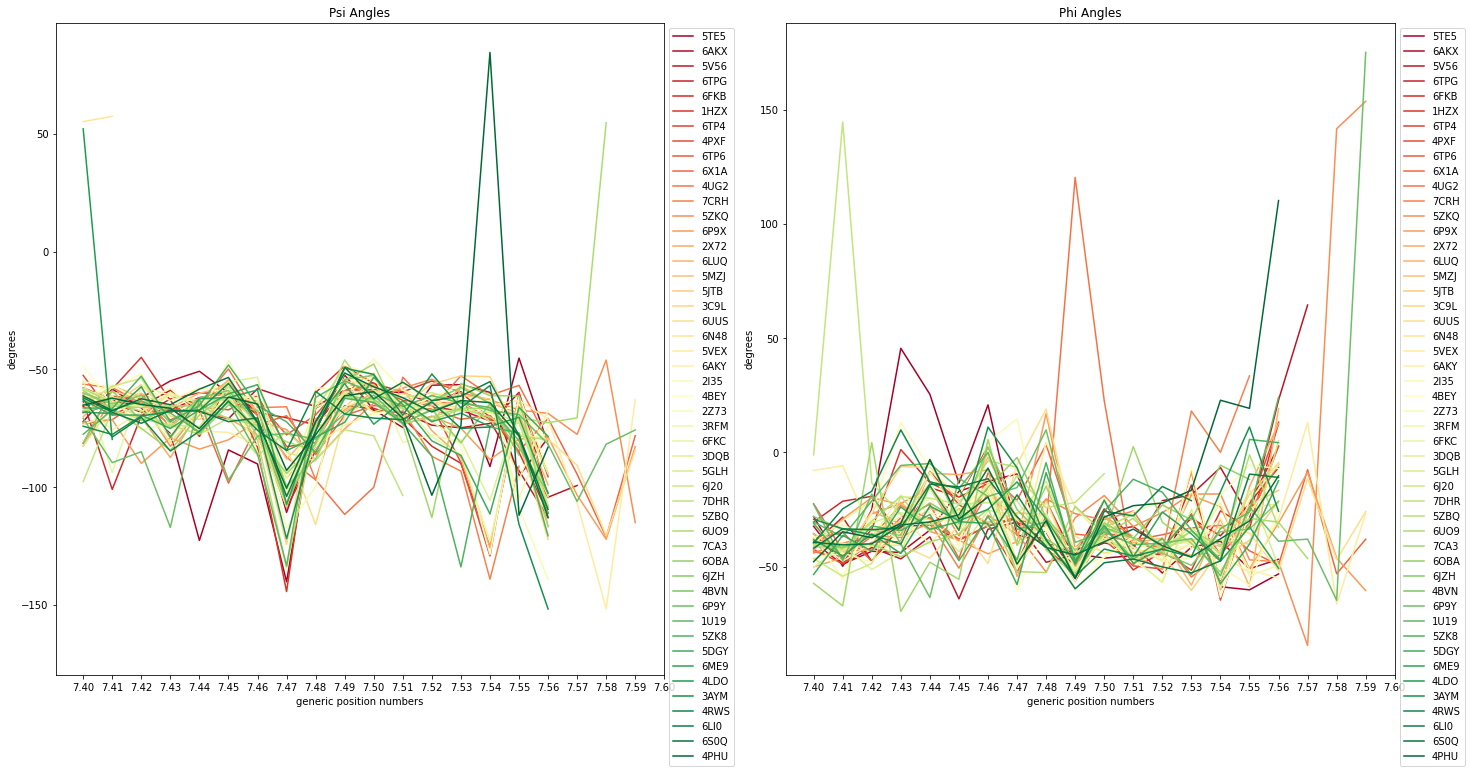

In [738]:
%matplotlib inline
data.plot_angles_for_gen_pos(region=[8.45, 8.55])
data.plot_angles_for_gen_pos(region=[7.40, 7.60])
data.plot_angles_for_gen_pos(region=[8.45, 8.55])

# CifLoader

In [312]:
# 1 get pdb list

In [313]:
# 2 check list of raw dataframes

In [314]:
# 3 if reload reload anyway, otw only process missing structures

In [315]:
# 4 save as pkl

In [316]:
# 5 load pkl individually (and the full table, numbering and mapping dataframes)

In [317]:
# 6 individually for each pdb generate position numbers

In [318]:
# 7 store structs

# StructLoader

In [319]:
# 8 load structs (structs dataloader) and table
# btw how do i get the affinities?

In [320]:
# 9 plot structs

In [321]:
# 10plot deltas (make interaction map based on genes)

In [322]:
# 11inut features

# GPROTEINS

# AFFINITIES